# Principal Component Analysis with RandomForest
## Train

PyTorch Version: 2.4.0+cu121
cpu
50 37
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
torch.Size([966, 150])
torch.Size([322, 150])


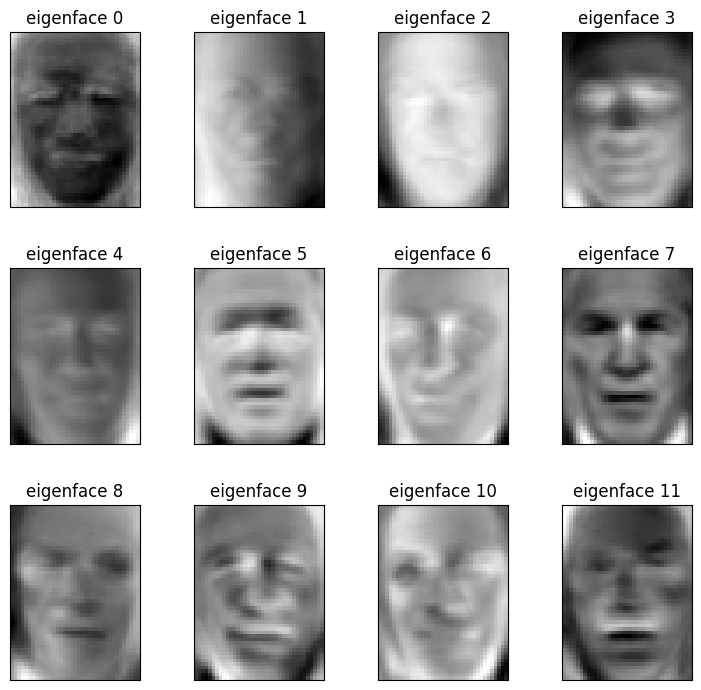

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import torch

# Check PyTorch
print("PyTorch Version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(data_home='./new_data_home2', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print(h, w)
# for machine learning we use the 2 data directly (as relative pixel # positions info is ignored by this model)
X = lfw_people.data

n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = torch.from_numpy(X_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled # dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data --> 1.STANDARDISATION
mean = torch.mean(X_train, dim=0)

X_train -= mean
X_test -= mean

#Eigen-decomposition
U, S, V = torch.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = torch.matmul(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
print(X_test_transformed.shape)

# Qualitative evaluation of the predictions using matplotlib
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()




## Evaluate

torch.Size([966])


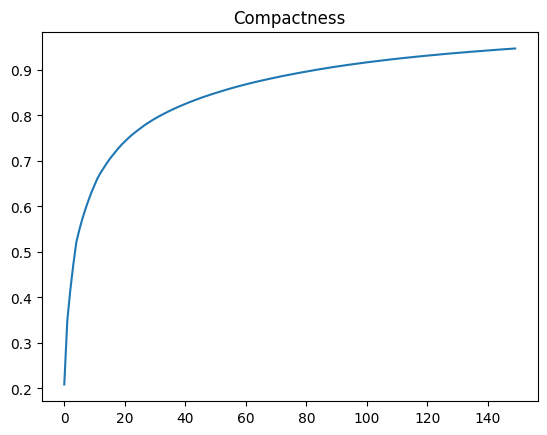

In [ ]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = torch.from_numpy(predictions)==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",torch.sum(correct))
print("Accuracy:",torch.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 4 1 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 3 2 1 3 3 3 6 3 3 4 2 5 3 4 1 3 6 6 3 3
 3 2 3 1 1 3 6 3 3 3 3 3 3 3 3 1 5 6 3 3 1 1 3 1 3 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 1 3 3 3 1 3 3 1 3
 1 1 1 3 3 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 1 1 3
 3 3 3 3 2 5 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 3 2 6 2 3 5 3 3 3 4 3 1 3 3 3 6
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 3 3 3 3 3 4 3 3 3 3 3 3 3 5 4 3 3 4 3 4 3 1 3
 3 3 3 3 1 3 4 6 1 6 1 6 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 2 3 5 3 3 3
 3 5 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 1 3 3 1 3 3 5 3]
Which Correct: tensor([ True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True, False, False, False, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  Tr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Simple CNN
## Train

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the LFW dataset
lfw_people = fetch_lfw_people(data_home='./new_data_home2', min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target
n_classes = lfw_people.target_names.shape[0]

# Preprocess the data
X = X[..., np.newaxis]  # Add channel dimension


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert labels to categorical one-hot encoding
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

# Define model parameters
depth = 32
batch_size = 16
epochs = 20

# Create the model
inputs = Input(shape=(X.shape[1], X.shape[2], 1))
net1 = Conv2D(depth, (3, 3), padding="same", activation="relu")(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(net1)
net2 = Conv2D(depth * 2, (3, 3), padding="same", activation="relu")(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(net2)
net3 = Conv2D(depth * 4, (3, 3), padding="same", activation="relu")(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(net3)
flat = Flatten()(pool3)
net4 = Dense(128, activation="relu")(flat)
output = Dense(n_classes, activation="softmax")(net4)

model = Model(inputs, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train, y_train_cat,
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True,
          validation_data=(X_test, y_test_cat))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 37, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 50, 37, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 9, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 486,919 (1.86 MB)

 Trainable params: 486,919 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.4106 - loss: 1.7552 - val_accuracy: 0.4534 - val_loss: 1.5958
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3989 - loss: 1.6738 - val_accuracy: 0.5373 - val_loss: 1.4048
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5516 - loss: 1.2992 - val_accuracy: 0.6708 - val_loss: 0.9811
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6635 - loss: 0.9120 - val_accuracy: 0.7795 - val_loss: 0.6938
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8032 - loss: 0.5903 - val_accuracy: 0.8199 - val_loss: 0.5987
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8774 - loss: 0.3760 - val_accuracy: 0.8292 - val_loss: 0.4802
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9428 - loss: 0.2165 - val_accuracy: 0.9037 - val_loss: 0.3634
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9608 - loss: 0.1265 - val_accuracy: 0.8913 - val_loss

## Evaluate

In [3]:
# Classify the test set
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(y_test, predictions, target_names=lfw_people.target_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.85      0.79        13
     Colin Powell       0.91      0.97      0.94        60
  Donald Rumsfeld       1.00      0.78      0.88        27
    George W Bush       0.95      0.97      0.96       146
Gerhard Schroeder       1.00      0.72      0.84        25
      Hugo Chavez       0.88      0.93      0.90        15
       Tony Blair       0.85      0.94      0.89        36

         accuracy                           0.92       322
        macro avg       0.90      0.88      0.88       322
     weighted avg       0.93      0.92      0.92       322

